In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [39]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'xs_tiny/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0) - 0.5 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
                aug = self.except_transform(image=img)
                img = aug['image'] 
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

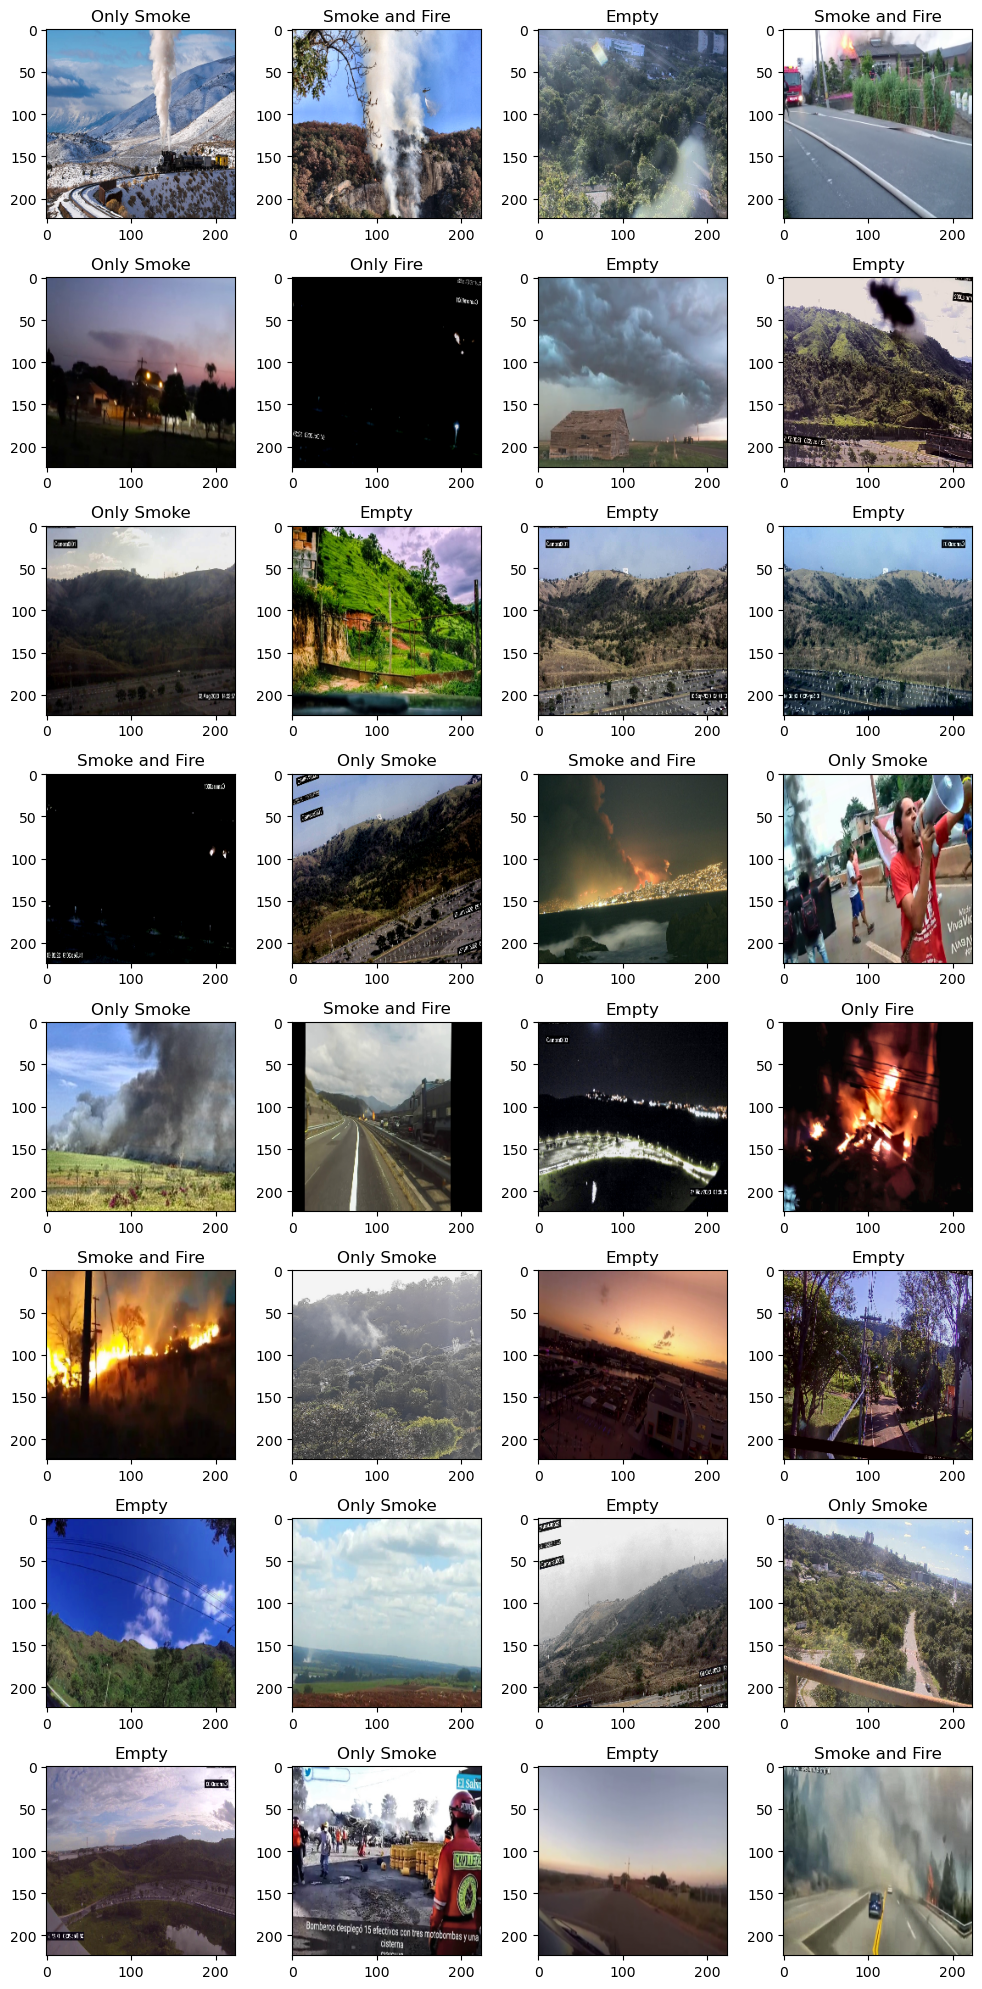

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = 2*smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': 2*self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 75 #100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[ 0.0513,  0.3094],
        [-0.0340,  0.5092],
        [ 0.0125,  0.3619],
        [ 0.0962,  0.3342]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mome

# Main Function

In [18]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        loss_fn = BCE_LOSS(device=DEVICE)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_bed_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    squeeze_model = main()

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE

***Start Training: 16:46:00

Initializing Weights

=== EPOCH 0/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
119.344     |87.543      |31.801      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
111.909     |85.915      |25.994      

SMOKE -> Precision: 0.566 - Recall: 0.372 - Accuracy: 0.561 - F1: 0.449
FIRE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.741 - F1: 0.000

Saving model with new best validation loss: 111.909

=== EPOCH 1/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
112.443     |85.801      |26.642      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
106.758     |83.134      |23.624      

SMOKE -> Precision: 0.628 - Recall: 0.515 - Accuracy: 0.620 - F1: 0.566
FIRE -> Precision: 0.769 - Recall: 0.550 - Accuracy: 0.841 - F1: 0.641

Saving model with new best validation loss: 106.758

=== EPOCH 2/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
108.786     |83.519      |25.267      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
100.383     |79.184      |21.199      

SMOKE -> Precision: 0.649 - Recall: 0.629 - Accuracy: 0.658 - F1: 0.639
FIRE -> Precision: 0.736 - Recall: 0.687 - Accuracy: 0.855 - F1: 0.711

Saving model with new best validation loss: 100.383

=== EPOCH 3/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
102.652     |80.112      |22.539      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
92.449      |74.254      |18.195      

SMOKE -> Precision: 0.700 - Recall: 0.658 - Accuracy: 0.700 - F1: 0.678
FIRE -> Precision: 0.798 - Recall: 0.733 - Accuracy: 0.883 - F1: 0.764

Saving model with new best validation loss: 92.449

=== EPOCH 4/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
98.520      |77.643      |20.877      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
88.506      |70.883      |17.623      

SMOKE -> Precision: 0.737 - Recall: 0.651 - Accuracy: 0.720 - F1: 0.691
FIRE -> Precision: 0.832 - Recall: 0.708 - Accuracy: 0.887 - F1: 0.765

Saving model with new best validation loss: 88.506

=== EPOCH 5/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
94.492      |74.972      |19.520      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
84.029      |68.721      |15.308      

SMOKE -> Precision: 0.700 - Recall: 0.774 - Accuracy: 0.731 - F1: 0.735
FIRE -> Precision: 0.786 - Recall: 0.831 - Accuracy: 0.898 - F1: 0.808

Saving model with new best validation loss: 84.029

=== EPOCH 6/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
90.692      |72.303      |18.389      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
81.744      |66.343      |15.401      

SMOKE -> Precision: 0.748 - Recall: 0.760 - Accuracy: 0.761 - F1: 0.754
FIRE -> Precision: 0.858 - Recall: 0.744 - Accuracy: 0.902 - F1: 0.797

Saving model with new best validation loss: 81.744

=== EPOCH 7/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
88.805      |70.893      |17.911      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
81.503      |66.583      |14.920      

SMOKE -> Precision: 0.830 - Recall: 0.533 - Accuracy: 0.723 - F1: 0.649
FIRE -> Precision: 0.873 - Recall: 0.752 - Accuracy: 0.907 - F1: 0.808

Saving model with new best validation loss: 81.503

=== EPOCH 8/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
86.496      |69.060      |17.436      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
74.278      |60.695      |13.583      

SMOKE -> Precision: 0.815 - Recall: 0.684 - Accuracy: 0.773 - F1: 0.744
FIRE -> Precision: 0.841 - Recall: 0.819 - Accuracy: 0.913 - F1: 0.830

Saving model with new best validation loss: 74.278

=== EPOCH 9/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
84.795      |67.716      |17.079      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
70.207      |57.058      |13.149      

SMOKE -> Precision: 0.780 - Recall: 0.797 - Accuracy: 0.794 - F1: 0.788
FIRE -> Precision: 0.818 - Recall: 0.875 - Accuracy: 0.917 - F1: 0.845

Saving model with new best validation loss: 70.207

=== EPOCH 10/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
83.100      |66.559      |16.541      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.205      |56.176      |13.029      

SMOKE -> Precision: 0.780 - Recall: 0.794 - Accuracy: 0.793 - F1: 0.787
FIRE -> Precision: 0.838 - Recall: 0.865 - Accuracy: 0.922 - F1: 0.851

Saving model with new best validation loss: 69.205

=== EPOCH 11/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
82.160      |65.611      |16.549      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.418      |56.508      |12.910      

SMOKE -> Precision: 0.754 - Recall: 0.857 - Accuracy: 0.797 - F1: 0.802
FIRE -> Precision: 0.854 - Recall: 0.856 - Accuracy: 0.925 - F1: 0.855

=== EPOCH 12/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
79.858      |63.715      |16.143      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.393      |53.194      |12.198      

SMOKE -> Precision: 0.827 - Recall: 0.769 - Accuracy: 0.811 - F1: 0.797
FIRE -> Precision: 0.853 - Recall: 0.877 - Accuracy: 0.929 - F1: 0.865

Saving model with new best validation loss: 65.393

=== EPOCH 13/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
78.930      |63.127      |15.803      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.385      |52.568      |11.817      

SMOKE -> Precision: 0.866 - Recall: 0.730 - Accuracy: 0.816 - F1: 0.792
FIRE -> Precision: 0.884 - Recall: 0.834 - Accuracy: 0.929 - F1: 0.858

Saving model with new best validation loss: 64.385

=== EPOCH 14/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
78.734      |62.573      |16.161      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.512      |52.192      |12.320      

SMOKE -> Precision: 0.857 - Recall: 0.746 - Accuracy: 0.818 - F1: 0.798
FIRE -> Precision: 0.861 - Recall: 0.850 - Accuracy: 0.926 - F1: 0.856

=== EPOCH 15/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
77.362      |61.679      |15.682      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.948      |50.583      |11.365      

SMOKE -> Precision: 0.800 - Recall: 0.864 - Accuracy: 0.830 - F1: 0.831
FIRE -> Precision: 0.888 - Recall: 0.853 - Accuracy: 0.934 - F1: 0.870

Saving model with new best validation loss: 61.948

=== EPOCH 16/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
76.691      |61.166      |15.525      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.541      |50.280      |12.261      

SMOKE -> Precision: 0.796 - Recall: 0.869 - Accuracy: 0.830 - F1: 0.831
FIRE -> Precision: 0.851 - Recall: 0.871 - Accuracy: 0.927 - F1: 0.861

=== EPOCH 17/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
75.431      |60.274      |15.157      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.239      |48.674      |11.565      

SMOKE -> Precision: 0.841 - Recall: 0.799 - Accuracy: 0.831 - F1: 0.820
FIRE -> Precision: 0.897 - Recall: 0.836 - Accuracy: 0.933 - F1: 0.866

Saving model with new best validation loss: 60.239

=== EPOCH 18/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
74.369      |59.383      |14.985      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.848      |49.354      |11.494      

SMOKE -> Precision: 0.866 - Recall: 0.773 - Accuracy: 0.833 - F1: 0.817
FIRE -> Precision: 0.909 - Recall: 0.823 - Accuracy: 0.933 - F1: 0.864

=== EPOCH 19/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
73.248      |58.508      |14.740      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.146      |55.062      |11.084      

SMOKE -> Precision: 0.894 - Recall: 0.669 - Accuracy: 0.803 - F1: 0.766
FIRE -> Precision: 0.909 - Recall: 0.839 - Accuracy: 0.937 - F1: 0.873

=== EPOCH 20/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
72.517      |58.030      |14.487      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.641      |44.996      |10.645      

SMOKE -> Precision: 0.863 - Recall: 0.830 - Accuracy: 0.855 - F1: 0.846
FIRE -> Precision: 0.887 - Recall: 0.874 - Accuracy: 0.938 - F1: 0.880

Saving model with new best validation loss: 55.641

=== EPOCH 21/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
71.374      |56.940      |14.434      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.831      |45.943      |10.888      

SMOKE -> Precision: 0.841 - Recall: 0.846 - Accuracy: 0.849 - F1: 0.843
FIRE -> Precision: 0.911 - Recall: 0.854 - Accuracy: 0.941 - F1: 0.881

=== EPOCH 22/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
70.191      |55.831      |14.359      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.018      |46.110      |10.908      

SMOKE -> Precision: 0.835 - Recall: 0.852 - Accuracy: 0.847 - F1: 0.843
FIRE -> Precision: 0.862 - Recall: 0.880 - Accuracy: 0.932 - F1: 0.871

=== EPOCH 23/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.482      |55.380      |14.102      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.604      |43.405      |11.200      

SMOKE -> Precision: 0.850 - Recall: 0.864 - Accuracy: 0.861 - F1: 0.857
FIRE -> Precision: 0.883 - Recall: 0.867 - Accuracy: 0.936 - F1: 0.875

Saving model with new best validation loss: 54.604

=== EPOCH 24/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.650      |55.350      |14.301      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.768      |44.900      |12.868      

SMOKE -> Precision: 0.811 - Recall: 0.897 - Accuracy: 0.850 - F1: 0.852
FIRE -> Precision: 0.793 - Recall: 0.931 - Accuracy: 0.919 - F1: 0.857

=== EPOCH 25/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.299      |55.103      |14.196      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.449      |44.849      |10.600      

SMOKE -> Precision: 0.793 - Recall: 0.934 - Accuracy: 0.851 - F1: 0.858
FIRE -> Precision: 0.871 - Recall: 0.895 - Accuracy: 0.939 - F1: 0.883

=== EPOCH 26/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.261      |53.403      |13.858      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.769      |42.550      |10.219      

SMOKE -> Precision: 0.808 - Recall: 0.909 - Accuracy: 0.852 - F1: 0.856
FIRE -> Precision: 0.882 - Recall: 0.898 - Accuracy: 0.943 - F1: 0.890

Saving model with new best validation loss: 52.769

=== EPOCH 27/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.221      |53.307      |13.914      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.313      |42.788      |10.525      

SMOKE -> Precision: 0.829 - Recall: 0.890 - Accuracy: 0.859 - F1: 0.859
FIRE -> Precision: 0.870 - Recall: 0.898 - Accuracy: 0.939 - F1: 0.884

=== EPOCH 28/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.341      |52.599      |13.742      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.266      |40.433      |9.832       

SMOKE -> Precision: 0.890 - Recall: 0.827 - Accuracy: 0.868 - F1: 0.857
FIRE -> Precision: 0.900 - Recall: 0.872 - Accuracy: 0.942 - F1: 0.886

Saving model with new best validation loss: 50.266

=== EPOCH 29/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.976      |51.889      |13.087      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.003      |45.422      |11.581      

SMOKE -> Precision: 0.781 - Recall: 0.939 - Accuracy: 0.844 - F1: 0.853
FIRE -> Precision: 0.837 - Recall: 0.923 - Accuracy: 0.933 - F1: 0.877

=== EPOCH 30/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.119      |51.571      |13.549      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.897      |41.285      |10.612      

SMOKE -> Precision: 0.819 - Recall: 0.921 - Accuracy: 0.865 - F1: 0.867
FIRE -> Precision: 0.858 - Recall: 0.905 - Accuracy: 0.937 - F1: 0.881

=== EPOCH 31/74 ===
Learning Rate = 0.001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.442      |52.218      |13.224      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.621      |43.498      |10.123      

SMOKE -> Precision: 0.898 - Recall: 0.783 - Accuracy: 0.853 - F1: 0.837
FIRE -> Precision: 0.932 - Recall: 0.845 - Accuracy: 0.944 - F1: 0.887

=== EPOCH 32/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.215      |50.178      |13.037      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.804      |39.112      |9.692       

SMOKE -> Precision: 0.900 - Recall: 0.825 - Accuracy: 0.872 - F1: 0.861
FIRE -> Precision: 0.927 - Recall: 0.852 - Accuracy: 0.944 - F1: 0.888

Saving model with new best validation loss: 48.804

=== EPOCH 33/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.806      |49.075      |12.731      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.332      |36.807      |9.525       

SMOKE -> Precision: 0.876 - Recall: 0.874 - Accuracy: 0.880 - F1: 0.875
FIRE -> Precision: 0.887 - Recall: 0.907 - Accuracy: 0.946 - F1: 0.897

Saving model with new best validation loss: 46.332

=== EPOCH 34/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.519      |48.727      |12.792      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.078      |39.238      |9.840       

SMOKE -> Precision: 0.828 - Recall: 0.925 - Accuracy: 0.872 - F1: 0.874
FIRE -> Precision: 0.875 - Recall: 0.917 - Accuracy: 0.944 - F1: 0.895

=== EPOCH 35/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.67it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.883      |48.997      |12.886      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.132      |36.238      |9.894       

SMOKE -> Precision: 0.889 - Recall: 0.874 - Accuracy: 0.887 - F1: 0.882
FIRE -> Precision: 0.904 - Recall: 0.883 - Accuracy: 0.945 - F1: 0.893

Saving model with new best validation loss: 46.132

=== EPOCH 36/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.289      |48.666      |12.623      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.789      |37.103      |9.686       

SMOKE -> Precision: 0.905 - Recall: 0.855 - Accuracy: 0.887 - F1: 0.879
FIRE -> Precision: 0.928 - Recall: 0.853 - Accuracy: 0.945 - F1: 0.889

=== EPOCH 37/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.016      |47.717      |12.299      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.812      |38.621      |10.192      

SMOKE -> Precision: 0.836 - Recall: 0.906 - Accuracy: 0.869 - F1: 0.870
FIRE -> Precision: 0.856 - Recall: 0.924 - Accuracy: 0.940 - F1: 0.889

=== EPOCH 38/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.477      |47.946      |12.530      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.426      |35.190      |9.236       

SMOKE -> Precision: 0.887 - Recall: 0.897 - Accuracy: 0.896 - F1: 0.892
FIRE -> Precision: 0.910 - Recall: 0.895 - Accuracy: 0.950 - F1: 0.903

Saving model with new best validation loss: 44.426

=== EPOCH 39/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.196      |47.550      |12.646      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.475      |36.643      |9.833       

SMOKE -> Precision: 0.890 - Recall: 0.858 - Accuracy: 0.881 - F1: 0.874
FIRE -> Precision: 0.914 - Recall: 0.868 - Accuracy: 0.944 - F1: 0.890

=== EPOCH 40/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.113      |47.559      |12.555      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.298      |34.839      |9.459       

SMOKE -> Precision: 0.880 - Recall: 0.895 - Accuracy: 0.891 - F1: 0.887
FIRE -> Precision: 0.911 - Recall: 0.878 - Accuracy: 0.946 - F1: 0.894

Saving model with new best validation loss: 44.298

=== EPOCH 41/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.089      |46.725      |12.364      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.951      |37.356      |9.595       

SMOKE -> Precision: 0.897 - Recall: 0.842 - Accuracy: 0.878 - F1: 0.869
FIRE -> Precision: 0.912 - Recall: 0.864 - Accuracy: 0.943 - F1: 0.888

=== EPOCH 42/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.751      |46.610      |12.140      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.891      |35.046      |9.844       

SMOKE -> Precision: 0.891 - Recall: 0.887 - Accuracy: 0.894 - F1: 0.889
FIRE -> Precision: 0.859 - Recall: 0.925 - Accuracy: 0.941 - F1: 0.891

=== EPOCH 43/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.063      |46.594      |12.470      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.120      |32.842      |9.278       

SMOKE -> Precision: 0.893 - Recall: 0.904 - Accuracy: 0.902 - F1: 0.898
FIRE -> Precision: 0.919 - Recall: 0.863 - Accuracy: 0.945 - F1: 0.890

Saving model with new best validation loss: 42.120

=== EPOCH 44/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.090      |46.138      |11.952      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.742      |39.237      |9.505       

SMOKE -> Precision: 0.808 - Recall: 0.963 - Accuracy: 0.872 - F1: 0.879
FIRE -> Precision: 0.891 - Recall: 0.899 - Accuracy: 0.945 - F1: 0.895

=== EPOCH 45/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.101      |45.033      |12.068      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.003      |34.029      |8.975       

SMOKE -> Precision: 0.882 - Recall: 0.911 - Accuracy: 0.899 - F1: 0.896
FIRE -> Precision: 0.903 - Recall: 0.898 - Accuracy: 0.949 - F1: 0.901

=== EPOCH 46/74 ===
Learning Rate = 0.0008



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.078      |44.901      |12.177      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.896      |34.543      |9.353       

SMOKE -> Precision: 0.894 - Recall: 0.873 - Accuracy: 0.889 - F1: 0.884
FIRE -> Precision: 0.898 - Recall: 0.897 - Accuracy: 0.947 - F1: 0.898

=== EPOCH 47/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.304      |44.625      |11.679      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.900      |33.018      |8.882       

SMOKE -> Precision: 0.887 - Recall: 0.915 - Accuracy: 0.903 - F1: 0.901
FIRE -> Precision: 0.920 - Recall: 0.888 - Accuracy: 0.951 - F1: 0.904

Saving model with new best validation loss: 41.900

=== EPOCH 48/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.188      |43.250      |11.938      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.664      |33.818      |8.846       

SMOKE -> Precision: 0.853 - Recall: 0.939 - Accuracy: 0.893 - F1: 0.894
FIRE -> Precision: 0.901 - Recall: 0.905 - Accuracy: 0.950 - F1: 0.903

=== EPOCH 49/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.015      |43.138      |11.877      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.125      |33.210      |8.914       

SMOKE -> Precision: 0.865 - Recall: 0.928 - Accuracy: 0.896 - F1: 0.895
FIRE -> Precision: 0.912 - Recall: 0.886 - Accuracy: 0.948 - F1: 0.899

=== EPOCH 50/74 ===
Learning Rate = 0.00064



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:48<00:00,  5.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.634      |43.022      |11.612      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.324      |37.892      |9.432       

SMOKE -> Precision: 0.821 - Recall: 0.956 - Accuracy: 0.879 - F1: 0.884
FIRE -> Precision: 0.863 - Recall: 0.927 - Accuracy: 0.943 - F1: 0.894

=== EPOCH 51/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.185      |42.505      |11.679      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.076      |31.226      |8.850       

SMOKE -> Precision: 0.885 - Recall: 0.925 - Accuracy: 0.906 - F1: 0.905
FIRE -> Precision: 0.932 - Recall: 0.878 - Accuracy: 0.952 - F1: 0.904

Saving model with new best validation loss: 40.076

=== EPOCH 52/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.639      |42.186      |11.453      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.470      |32.407      |9.064       

SMOKE -> Precision: 0.909 - Recall: 0.888 - Accuracy: 0.903 - F1: 0.898
FIRE -> Precision: 0.943 - Recall: 0.854 - Accuracy: 0.949 - F1: 0.896

=== EPOCH 53/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.237      |41.824      |11.413      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.179      |30.575      |8.604       

SMOKE -> Precision: 0.904 - Recall: 0.909 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.930 - Recall: 0.886 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 39.179

=== EPOCH 54/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.220      |42.071      |11.150      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.076      |33.413      |8.664       

SMOKE -> Precision: 0.928 - Recall: 0.852 - Accuracy: 0.897 - F1: 0.889
FIRE -> Precision: 0.930 - Recall: 0.893 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 55/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.141      |41.899      |11.243      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.311      |31.781      |8.529       

SMOKE -> Precision: 0.872 - Recall: 0.944 - Accuracy: 0.906 - F1: 0.906
FIRE -> Precision: 0.915 - Recall: 0.902 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 56/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.165      |42.014      |11.152      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.747      |36.129      |9.618       

SMOKE -> Precision: 0.931 - Recall: 0.827 - Accuracy: 0.887 - F1: 0.876
FIRE -> Precision: 0.950 - Recall: 0.852 - Accuracy: 0.950 - F1: 0.898

=== EPOCH 57/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.531      |40.395      |11.136      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.540      |31.609      |8.931       

SMOKE -> Precision: 0.901 - Recall: 0.903 - Accuracy: 0.905 - F1: 0.902
FIRE -> Precision: 0.943 - Recall: 0.868 - Accuracy: 0.952 - F1: 0.904

=== EPOCH 58/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.390      |40.326      |11.063      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.391      |30.788      |8.603       

SMOKE -> Precision: 0.918 - Recall: 0.896 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.932 - Recall: 0.890 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 59/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.420      |40.291      |11.129      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.108      |34.061      |9.047       

SMOKE -> Precision: 0.925 - Recall: 0.855 - Accuracy: 0.897 - F1: 0.889
FIRE -> Precision: 0.955 - Recall: 0.864 - Accuracy: 0.954 - F1: 0.907

=== EPOCH 60/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.745      |39.890      |10.855      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.759      |30.447      |8.312       

SMOKE -> Precision: 0.879 - Recall: 0.932 - Accuracy: 0.906 - F1: 0.905
FIRE -> Precision: 0.924 - Recall: 0.898 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 38.759

=== EPOCH 61/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.194      |39.012      |11.182      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.428      |30.941      |8.486       

SMOKE -> Precision: 0.910 - Recall: 0.896 - Accuracy: 0.907 - F1: 0.903
FIRE -> Precision: 0.930 - Recall: 0.894 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 62/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.114      |38.115      |10.999      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.203      |30.186      |9.017       

SMOKE -> Precision: 0.889 - Recall: 0.934 - Accuracy: 0.912 - F1: 0.911
FIRE -> Precision: 0.883 - Recall: 0.922 - Accuracy: 0.948 - F1: 0.902

=== EPOCH 63/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.893      |38.929      |10.964      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.721      |31.048      |8.672       

SMOKE -> Precision: 0.894 - Recall: 0.905 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.927 - Recall: 0.898 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 64/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.423      |37.594      |10.829      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.259      |30.949      |8.310       

SMOKE -> Precision: 0.871 - Recall: 0.950 - Accuracy: 0.908 - F1: 0.909
FIRE -> Precision: 0.919 - Recall: 0.901 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 65/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.778      |39.062      |10.716      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.443      |29.771      |8.673       

SMOKE -> Precision: 0.914 - Recall: 0.896 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.926 - Recall: 0.896 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 38.443

=== EPOCH 66/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.349      |37.530      |10.819      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.019      |29.395      |8.624       

SMOKE -> Precision: 0.905 - Recall: 0.916 - Accuracy: 0.913 - F1: 0.911
FIRE -> Precision: 0.921 - Recall: 0.899 - Accuracy: 0.954 - F1: 0.910

Saving model with new best validation loss: 38.019

=== EPOCH 67/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.897      |38.100      |10.797      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.835      |29.081      |8.754       

SMOKE -> Precision: 0.903 - Recall: 0.927 - Accuracy: 0.917 - F1: 0.915
FIRE -> Precision: 0.911 - Recall: 0.907 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 37.835

=== EPOCH 68/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.502      |37.876      |10.627      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.017      |29.355      |8.662       

SMOKE -> Precision: 0.888 - Recall: 0.934 - Accuracy: 0.912 - F1: 0.910
FIRE -> Precision: 0.900 - Recall: 0.920 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 69/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.481      |37.975      |10.506      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.460      |29.995      |8.465       

SMOKE -> Precision: 0.904 - Recall: 0.908 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.924 - Recall: 0.895 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 70/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.151      |37.443      |10.709      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.370      |29.483      |8.888       

SMOKE -> Precision: 0.908 - Recall: 0.913 - Accuracy: 0.914 - F1: 0.911
FIRE -> Precision: 0.938 - Recall: 0.886 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 71/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.229      |36.846      |10.383      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.402      |29.678      |8.724       

SMOKE -> Precision: 0.916 - Recall: 0.898 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.939 - Recall: 0.878 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 72/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.138      |36.523      |10.615      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.941      |28.540      |8.401       

SMOKE -> Precision: 0.898 - Recall: 0.925 - Accuracy: 0.913 - F1: 0.911
FIRE -> Precision: 0.933 - Recall: 0.896 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 36.941

=== EPOCH 73/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:48<00:00,  5.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.296      |36.640      |10.656      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.602      |29.152      |8.450       

SMOKE -> Precision: 0.888 - Recall: 0.934 - Accuracy: 0.912 - F1: 0.911
FIRE -> Precision: 0.919 - Recall: 0.905 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 74/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:47<00:00,  5.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.774      |36.374      |10.401      



Validating: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:08<00:00,  8.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.742      |28.255      |8.487       

SMOKE -> Precision: 0.900 - Recall: 0.924 - Accuracy: 0.914 - F1: 0.912
FIRE -> Precision: 0.910 - Recall: 0.913 - Accuracy: 0.954 - F1: 0.911

Saving model with new best validation loss: 36.742

***Script finished: 17:56:22

Time elapsed: 1:10:22.863741


# Confusion Matrix

In [40]:
smoke_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)
fire_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)

In [41]:
def get_conf_mtx(loader, model, device):

    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x) 
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        #yhat = torch.sigmoid(out.detach())
        yhat = out.detach() # La metrica entiende que son logits y aplica sigmoid
        smoke_conf_mtx_metric.update(yhat[..., 0], y[..., 0])
        fire_conf_mtx_metric.update(yhat[..., 1], y[..., 1])
    
    smoke_conf_mtx = smoke_conf_mtx_metric.compute()
    fire_conf_mtx = fire_conf_mtx_metric.compute()
    smoke_conf_mtx_metric.reset()
    fire_conf_mtx_metric.reset()
    
    return smoke_conf_mtx, fire_conf_mtx

In [42]:
smoke_conf_mtx, fire_conf_mtx = get_conf_mtx(loader=val_loader,
                                             model=squeeze_model,
                                             device=DEVICE)
print(smoke_conf_mtx)

Validating:   0%|                                                                                                                     | 0/67 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 784.00 MiB. GPU 

In [ ]:
# conf_mtx = get_conf_mtx(loader=conf_loader,
#                         model=squeeze_model,
#                         device=DEVICE)
# smoke_conf_mtx = conf_mtx[0]
# fire_conf_mtx = conf_mtx[1]

### Smoke confusion matrix

### Fire confusion matrix

In [ ]:
# val_transform = A.Compose([
#     A.Resize(IMG_H, IMG_W, p=1),
#     #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
#     ToTensorV2(p=1),
#     ]
# )

# val_dataset = DFireDataset(img_h = IMG_H,
#                            img_w = IMG_W,
#                            img_dir = VAL_IMG_DIR,
#                            label_dir = VAL_LABEL_DIR,
#                            num_classes = N_CLASSES,
#                            ds_len=512,
#                            transform=val_transform)

# # LOADER
# plot_loader = DataLoader(dataset=val_dataset,
#                          batch_size=BATCH_SIZE,
#                          num_workers=NUM_WORKERS,
#                          pin_memory=PIN_MEMORY,
#                          shuffle=True,
#                          drop_last=True)



In [ ]:
# view_model = BED_CLASSIFIER(num_classes=N_CLASSES)
# model_file = log_path + 'bed_classifier_5epoch.pt'

# print(model_file)

# checkpoint = torch.load(model_file, map_location=torch.device('cpu'))
# view_model.load_state_dict(checkpoint['model_state_dict'])

# view_model.eval() 

In [ ]:
# import matplotlib.patches as patches 

In [ ]:
# for i, (img, label) in enumerate(plot_loader):

#     fig, ax = plt.subplots(1,4, figsize=(10, 20))
#     print(ax.shape)
#     for idx in range(4):
#             plt.subplot(1, 4, idx+1)
#             plt.imshow(img[idx].permute(1, 2, 0))

#             label_txt = ""
#             print(f'Label: {label[idx]}')
#             if label[idx, 0] == 1 and label[idx, 1] == 1:
#                 label_txt += "Smoke and Fire"
#             elif label[idx, 0] == 1 and label[idx, 1] == 0:
#                 label_txt += "Only Smoke"
#             elif label[idx, 0] == 0 and label[idx, 1] == 1:
#                 label_txt += "Only Fire"
#             else:
#                 label_txt += "Empty"

#             pred = torch.sigmoid( view_model(img[idx].unsqueeze(dim=0) / 255.) )
#             print(f'Pred: {pred}')
#             pred_txt = ""
#             if pred[..., 0] > 0.5 and pred[..., 1] > 0.5:
#                 pred_txt += "Smoke and Fire"
#             elif pred[..., 0] > 0.5 and pred[..., 1] < 0.5:
#                 pred_txt += "Only Smoke"
#             elif pred[..., 0] < 0.5 and pred[..., 1] > 0.5:
#                 pred_txt += "Only Fire"
#             else:
#                 pred_txt += "Empty"

#             if pred_txt == label_txt:
#                 rect = patches.Rectangle((1, 1), IMG_W-3, IMG_W-3, linewidth=3, edgecolor='g', facecolor="none")
#             else:
#                 rect = patches.Rectangle((1, 1), IMG_W-3, IMG_H-3, linewidth=3, edgecolor='r', facecolor="none")
                
#             ax[idx].add_patch(rect)
            
#             title = "Label: " + label_txt + " | Pred: " + pred_txt
#             plt.title(title, fontsize=8)

#             if (idx == 4):
#                 break
#     plt.tight_layout()
#     plt.show()
#     break

# Plot Results

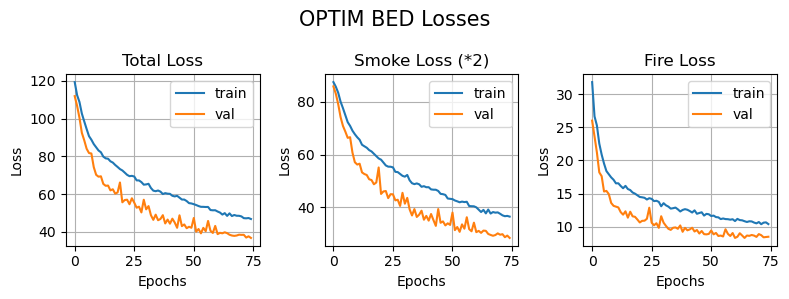

In [43]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss (*2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()